In [1]:
import time
import torch
import json
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

from models_package.models import Teacher, Student

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 300 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
patience = 5  # for early stopping
lmda = 3
batch_size = 330
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [6]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):
        # Define the original class labels

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data['images']

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            

        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            return remapped_label
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [7]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [8]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        # Option 1: Return a placeholder tensor (adapt the shape to match your data)
        # return torch.tensor([]), torch.tensor([])
        # Option 2: Raise an exception
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [9]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


trainloader = DataLoader(train_dataset, 
                         batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), batch_size=batch_size),
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)




Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


# Start Training Process

In [10]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()



In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix

def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes=30):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
# teacher_model.fc = nn.Linear(512,30)
student_model = torchvision.models.resnet18(weights=None).to(device)
student_model.fc = nn.Linear(512,30)


# # Load teacher
teacher_model = torch.load('teacher_model_ckd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)




<All keys matched successfully>

### This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).

In [13]:
class Adversary(nn.Module):
    def __init__(self, input_size=30):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()




In [14]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, epochs, patience=5):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)



In [15]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, epochs):

  for epoch in range(epochs):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)



In [16]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.68s/it]


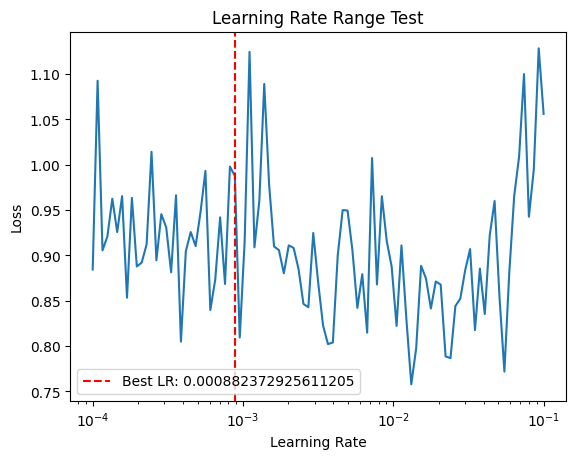

Best learning rate: 0.000882372925611205
0.000882372925611205


In [17]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
best_lr = train_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [18]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [19]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, epochs, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}| Validation Accuracy: {accuracy * 100:.2f}%')
            
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_wider_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_wider_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")

# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, student, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            student.eval()
            student.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            student_output = student(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, 
                                              criterion, adv_criterion, optimizer, scheduler, 
                                              device, alpha, temperature, epochs, lmda, patience=5):
    teacher.eval()
    teacher.to(device)
    num_classes = len(class_labels)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []
    for epoch in range(epochs):
        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studetached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studetached, one_hot_labels), dim=1)
            
            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            

            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            
            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            loss = alpha * kd_loss + (1 - alpha) * ce_loss - lmda * adversary_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            # epoch_disparity += disparity

        
        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studetached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studetached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()

                
                val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss - lmda * val_adversary_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()
        
        file_path = f'validation{lmda}.txt'
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")
        
        print(f"Data has been appended to {file_path}")

100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 1/300, Train Loss:  0.776978 Val Loss:  0.505661| Validation Accuracy: 86.48%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 2/300, Train Loss:  0.707730 Val Loss:  0.456062| Validation Accuracy: 88.24%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 3/300, Train Loss:  0.675309 Val Loss:  0.423788| Validation Accuracy: 89.28%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.67s/it]


Epoch 4/300, Train Loss:  0.644458 Val Loss:  0.400315| Validation Accuracy: 89.81%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 5/300, Train Loss:  0.617201 Val Loss:  0.379828| Validation Accuracy: 90.47%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 6/300, Train Loss:  0.605840 Val Loss:  0.362245| Validation Accuracy: 91.02%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 7/300, Train Loss:  0.575578 Val Loss:  0.346432| Validation Accuracy: 91.34%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 8/300, Train Loss:  0.567192 Val Loss:  0.331819| Validation Accuracy: 91.49%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 9/300, Train Loss:  0.563136 Val Loss:  0.318272| Validation Accuracy: 91.98%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 10/300, Train Loss:  0.541299 Val Loss:  0.306800| Validation Accuracy: 92.73%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 11/300, Train Loss:  0.537384 Val Loss:  0.296658| Validation Accuracy: 93.02%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 12/300, Train Loss:  0.530814 Val Loss:  0.285500| Validation Accuracy: 93.31%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 13/300, Train Loss:  0.508003 Val Loss:  0.277400| Validation Accuracy: 93.54%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]


Epoch 14/300, Train Loss:  0.494671 Val Loss:  0.267894| Validation Accuracy: 93.60%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 15/300, Train Loss:  0.494236 Val Loss:  0.259866| Validation Accuracy: 94.03%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 16/300, Train Loss:  0.478912 Val Loss:  0.250687| Validation Accuracy: 94.44%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 17/300, Train Loss:  0.473443 Val Loss:  0.242706| Validation Accuracy: 94.58%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 18/300, Train Loss:  0.464955 Val Loss:  0.235862| Validation Accuracy: 94.82%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 19/300, Train Loss:  0.464913 Val Loss:  0.228057| Validation Accuracy: 95.05%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 20/300, Train Loss:  0.446906 Val Loss:  0.220026| Validation Accuracy: 95.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 21/300, Train Loss:  0.435514 Val Loss:  0.213575| Validation Accuracy: 95.37%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 22/300, Train Loss:  0.429478 Val Loss:  0.207264| Validation Accuracy: 95.51%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 23/300, Train Loss:  0.427927 Val Loss:  0.199091| Validation Accuracy: 95.60%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 24/300, Train Loss:  0.426619 Val Loss:  0.194110| Validation Accuracy: 96.00%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 25/300, Train Loss:  0.418136 Val Loss:  0.188002| Validation Accuracy: 96.15%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 26/300, Train Loss:  0.398864 Val Loss:  0.182357| Validation Accuracy: 96.32%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 27/300, Train Loss:  0.399019 Val Loss:  0.175409| Validation Accuracy: 96.52%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 28/300, Train Loss:  0.398693 Val Loss:  0.170630| Validation Accuracy: 96.58%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 29/300, Train Loss:  0.393743 Val Loss:  0.164744| Validation Accuracy: 96.70%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 30/300, Train Loss:  0.370887 Val Loss:  0.159511| Validation Accuracy: 96.93%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 31/300, Train Loss:  0.374550 Val Loss:  0.157669| Validation Accuracy: 96.90%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 32/300, Train Loss:  0.375945 Val Loss:  0.157240| Validation Accuracy: 96.99%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 33/300, Train Loss:  0.372244 Val Loss:  0.157224| Validation Accuracy: 96.93%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 34/300, Train Loss:  0.374309 Val Loss:  0.155864| Validation Accuracy: 96.96%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 35/300, Train Loss:  0.366616 Val Loss:  0.155326| Validation Accuracy: 96.99%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 36/300, Train Loss:  0.365888 Val Loss:  0.154893| Validation Accuracy: 96.99%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 37/300, Train Loss:  0.381986 Val Loss:  0.154543| Validation Accuracy: 96.93%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]


Epoch 38/300, Train Loss:  0.367928 Val Loss:  0.154148| Validation Accuracy: 97.05%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 39/300, Train Loss:  0.371475 Val Loss:  0.153416| Validation Accuracy: 97.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 40/300, Train Loss:  0.368156 Val Loss:  0.153461| Validation Accuracy: 97.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 41/300, Train Loss:  0.373390 Val Loss:  0.152430| Validation Accuracy: 97.22%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 42/300, Train Loss:  0.366138 Val Loss:  0.152046| Validation Accuracy: 97.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 43/300, Train Loss:  0.375830 Val Loss:  0.151665| Validation Accuracy: 97.10%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 44/300, Train Loss:  0.369861 Val Loss:  0.151193| Validation Accuracy: 97.19%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 45/300, Train Loss:  0.364194 Val Loss:  0.150573| Validation Accuracy: 97.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 46/300, Train Loss:  0.359712 Val Loss:  0.149463| Validation Accuracy: 97.19%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 47/300, Train Loss:  0.365110 Val Loss:  0.148557| Validation Accuracy: 97.16%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 48/300, Train Loss:  0.373631 Val Loss:  0.148003| Validation Accuracy: 97.31%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 49/300, Train Loss:  0.366470 Val Loss:  0.148199| Validation Accuracy: 97.36%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 50/300, Train Loss:  0.352780 Val Loss:  0.147711| Validation Accuracy: 97.25%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 51/300, Train Loss:  0.355348 Val Loss:  0.147464| Validation Accuracy: 97.28%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 52/300, Train Loss:  0.363749 Val Loss:  0.146697| Validation Accuracy: 97.34%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]


Epoch 53/300, Train Loss:  0.358418 Val Loss:  0.146451| Validation Accuracy: 97.31%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]


Epoch 54/300, Train Loss:  0.355815 Val Loss:  0.145317| Validation Accuracy: 97.28%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 55/300, Train Loss:  0.357139 Val Loss:  0.145072| Validation Accuracy: 97.39%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 56/300, Train Loss:  0.359061 Val Loss:  0.144814| Validation Accuracy: 97.28%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 57/300, Train Loss:  0.355343 Val Loss:  0.144224| Validation Accuracy: 97.42%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 58/300, Train Loss:  0.361750 Val Loss:  0.144092| Validation Accuracy: 97.42%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 59/300, Train Loss:  0.350000 Val Loss:  0.142944| Validation Accuracy: 97.34%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 60/300, Train Loss:  0.357349 Val Loss:  0.142758| Validation Accuracy: 97.42%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 61/300, Train Loss:  0.353551 Val Loss:  0.142842| Validation Accuracy: 97.45%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 62/300, Train Loss:  0.356893 Val Loss:  0.142743| Validation Accuracy: 97.34%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 63/300, Train Loss:  0.349004 Val Loss:  0.142933| Validation Accuracy: 97.42%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 64/300, Train Loss:  0.348783 Val Loss:  0.142329| Validation Accuracy: 97.39%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 65/300, Train Loss:  0.353426 Val Loss:  0.142228| Validation Accuracy: 97.39%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 66/300, Train Loss:  0.352886 Val Loss:  0.143016| Validation Accuracy: 97.42%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 67/300, Train Loss:  0.353621 Val Loss:  0.142260| Validation Accuracy: 97.45%


100%|███████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch 68/300, Train Loss:  0.351037 Val Loss:  0.142319| Validation Accuracy: 97.42%
Early stopping


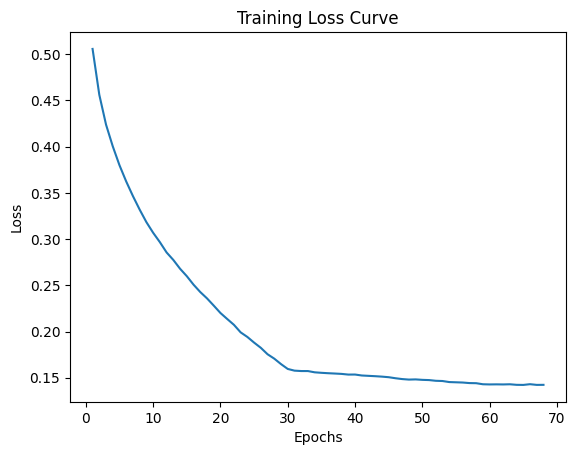

Finished Training Teacher
teacher weights and architecture saved and exported


100%|███████████████████████████████████████████| 31/31 [01:51<00:00,  3.59s/it]


*******Epoch 0: loss - 1.009620189666748


100%|███████████████████████████████████████████| 31/31 [01:51<00:00,  3.61s/it]


*******Epoch 1: loss - 0.9647866852821843


100%|███████████████████████████████████████████| 31/31 [01:50<00:00,  3.56s/it]


*******Epoch 2: loss - 0.9580168185695526


100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


Average Pretrain Adversary epoch loss:  2.6654849975339827


100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Pretrain Adversary epoch loss:  0.5772194141341794


100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Pretrain Adversary epoch loss:  0.3495949900919391
Epoch Number 0, Lambda: 0


100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.2609400244489793


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.954155 Val Loss:  1.087008*****
*****Validation Accuracy: 11.50%*****
*****Total Avg Disparity: 0.024429134111058032*****

Class Parade: Recall Difference = 0.007141287629092552
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.03872549019

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.24574667407620338


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.947015 Val Loss:  1.083764*****
*****Validation Accuracy: 11.58%*****
*****Total Avg Disparity: 0.013402839058431357*****

Class Parade: Recall Difference = -0.010382333553065282
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = -0.000306372

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.2239637379684756


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.953281 Val Loss:  1.081271*****
*****Validation Accuracy: 11.73%*****
*****Total Avg Disparity: 0.020236232448896607*****

Class Parade: Recall Difference = -0.0022522522522522292
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.003615196

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.2286709806611461


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


*****Epoch 1/300*****
*****Train Loss:  0.948745 Val Loss:  1.078171*****
*****Validation Accuracy: 12.40%*****
*****Total Avg Disparity: 0.013947072045928497*****

Class Parade: Recall Difference = 0.009778070753680534
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.03088235294

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.2205515883622631


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


*****Epoch 1/300*****
*****Train Loss:  0.947110 Val Loss:  1.074867*****
*****Validation Accuracy: 13.03%*****
*****Total Avg Disparity: 0.03525790794416039*****

Class Parade: Recall Difference = 0.07448912326961105
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.0307598039215

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.21573214425194648


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.940246 Val Loss:  1.073366*****
*****Validation Accuracy: 13.12%*****
*****Total Avg Disparity: 0.040788140524528095*****

Class Parade: Recall Difference = 0.03142166556800707
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.038725490196

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.20597085693190176


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.941252 Val Loss:  1.070833*****
*****Validation Accuracy: 13.50%*****
*****Total Avg Disparity: 0.019482147732555206*****

Class Parade: Recall Difference = 0.027301691935838313
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.03088235294

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.1957575414449938


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.936962 Val Loss:  1.067619*****
*****Validation Accuracy: 13.81%*****
*****Total Avg Disparity: 0.027996469057892177*****

Class Parade: Recall Difference = 0.050098879367172056
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.01893382352

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.1883985871268857


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]


*****Epoch 1/300*****
*****Train Loss:  0.938644 Val Loss:  1.065634*****
*****Validation Accuracy: 13.55%*****
*****Total Avg Disparity: 0.03598966234589953*****

Class Parade: Recall Difference = 0.06646890793232252
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.0189338235294

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.18618834595526418


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.934543 Val Loss:  1.062153*****
*****Validation Accuracy: 13.87%*****
*****Total Avg Disparity: 0.045680055882936554*****

Class Parade: Recall Difference = 0.051472203911228365
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = -0.0553921568

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.18145804203325702


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.934040 Val Loss:  1.060283*****
*****Validation Accuracy: 13.90%*****
*****Total Avg Disparity: 0.01658471516501255*****

Class Parade: Recall Difference = 0.03246539222148981
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.0069240196078

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.1817920890546614


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.929883 Val Loss:  1.058242*****
*****Validation Accuracy: 14.05%*****
*****Total Avg Disparity: 0.025441378613085375*****

Class Parade: Recall Difference = 0.031092067677433444
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.02647058823

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.17221346449467442


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.929769 Val Loss:  1.055550*****
*****Validation Accuracy: 14.02%*****
*****Total Avg Disparity: 0.04399344458574559*****

Class Parade: Recall Difference = 0.051472203911228365
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.049938725490

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.51s/it]


Average Adversary epoch loss: 0.16797614578277834


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.82s/it]


*****Epoch 1/300*****
*****Train Loss:  0.928245 Val Loss:  1.053935*****
*****Validation Accuracy: 14.10%*****
*****Total Avg Disparity: 0.04909473929614646*****

Class Parade: Recall Difference = 0.056855636123928854
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 0.077267156862

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.16191660060036567


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.927251 Val Loss:  1.050664*****
*****Validation Accuracy: 14.31%*****
*****Total Avg Disparity: 0.023563860177310547*****

Class Parade: Recall Difference = 0.028345418589320936
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = -0.00261848651479445
Class Running: Recall Difference = 0.0
Class Basketball: Recall Differenc

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.16476985571845884


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.923755 Val Loss:  1.047530*****
*****Validation Accuracy: 14.42%*****
*****Total Avg Disparity: 0.03521004596280116*****

Class Parade: Recall Difference = 0.045869039771478826
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.027232259753862256
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.15768221164903334


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


*****Epoch 1/300*****
*****Train Loss:  0.921104 Val Loss:  1.044819*****
*****Validation Accuracy: 14.57%*****
*****Total Avg Disparity: 0.03966373786303602*****

Class Parade: Recall Difference = 0.04987914744012312
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.05708300602251898
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference =

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.1607086499852519


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.917474 Val Loss:  1.042139*****
*****Validation Accuracy: 14.83%*****
*****Total Avg Disparity: 0.03975137700469111*****

Class Parade: Recall Difference = 0.04449571522742257
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0869337522911757
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.15447331532355277


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


*****Epoch 1/300*****
*****Train Loss:  0.920277 Val Loss:  1.039094*****
*****Validation Accuracy: 14.74%*****
*****Total Avg Disparity: 0.03904188332111258*****

Class Parade: Recall Difference = 0.06602944407822453
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0869337522911757
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.15493258353202574


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.912848 Val Loss:  1.037153*****
*****Validation Accuracy: 15.15%*****
*****Total Avg Disparity: 0.04616570022422671*****

Class Parade: Recall Difference = 0.05388925510876719
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0869337522911757
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference = 

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.15339931989869765


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.910389 Val Loss:  1.033145*****
*****Validation Accuracy: 15.32%*****
*****Total Avg Disparity: 0.04079843749952786*****

Class Parade: Recall Difference = 0.03900241705119756
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10185912542550407
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference =

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.15105754281243972


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.82s/it]


*****Epoch 1/300*****
*****Train Loss:  0.906953 Val Loss:  1.029921*****
*****Validation Accuracy: 15.38%*****
*****Total Avg Disparity: 0.0427361870595145*****

Class Parade: Recall Difference = 0.018512414853878223
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.08431526577638127
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference =

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.14976122134154843


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.74s/it]


*****Epoch 1/300*****
*****Train Loss:  0.910268 Val Loss:  1.026629*****
*****Validation Accuracy: 15.67%*****
*****Total Avg Disparity: 0.041208908114955776*****

Class Parade: Recall Difference = 0.02801582069874753
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.08431526577638127
Class Running: Recall Difference = 0.0
Class Basketball: Recall Difference 

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.1480605943549064


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.905464 Val Loss:  1.024531*****
*****Validation Accuracy: 15.93%*****
*****Total Avg Disparity: 0.050897252502576984*****

Class Parade: Recall Difference = 0.045649307844429776
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0954248366013072
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.06677140612725846
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.14857711618946445


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.903619 Val Loss:  1.021405*****
*****Validation Accuracy: 15.84%*****
*****Total Avg Disparity: 0.056632669890313826*****

Class Parade: Recall Difference = 0.034882443419028686
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.10653594771241831
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.06677140612725846
Class Running: Recall Difference = 0.0
Class Basketball: 

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.14742178205520876


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


*****Epoch 1/300*****
*****Train Loss:  0.899664 Val Loss:  1.017357*****
*****Validation Accuracy: 15.87%*****
*****Total Avg Disparity: 0.053042609183757375*****

Class Parade: Recall Difference = 0.03477257745550422
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0954248366013072
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.11416601204503796
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.45s/it]


Average Adversary epoch loss: 0.14453658317365953


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.895739 Val Loss:  1.015622*****
*****Validation Accuracy: 16.45%*****
*****Total Avg Disparity: 0.050399110065465325*****

Class Parade: Recall Difference = 0.033399252911448074
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0954248366013072
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.08431526577638127
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.14418450214209094


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.82s/it]


*****Epoch 1/300*****
*****Train Loss:  0.897691 Val Loss:  1.010853*****
*****Validation Accuracy: 16.77%*****
*****Total Avg Disparity: 0.05133335723729576*****

Class Parade: Recall Difference = 0.0482860909690177
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.07320261437908498
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0816967792615868
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.14474288470322086


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.892069 Val Loss:  1.007637*****
*****Validation Accuracy: 16.94%*****
*****Total Avg Disparity: 0.0574950648993367*****

Class Parade: Recall Difference = 0.03477257745550422
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.07320261437908498
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.0816967792615868
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.51s/it]


Average Adversary epoch loss: 0.14239283074294368


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.889236 Val Loss:  1.003451*****
*****Validation Accuracy: 17.49%*****
*****Total Avg Disparity: 0.06343490200472732*****

Class Parade: Recall Difference = 0.03614590199956047
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.06209150326797388
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10892903901544905
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.140342615544796


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.890430 Val Loss:  1.004459*****
*****Validation Accuracy: 17.61%*****
*****Total Avg Disparity: 0.06360363543177974*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.11154752553024352
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.1410666843575816


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.887823 Val Loss:  1.003403*****
*****Validation Accuracy: 17.43%*****
*****Total Avg Disparity: 0.06080017286171816*****

Class Parade: Recall Difference = 0.02125906394199073
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.039869281045751645
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.11154752553024352
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.51s/it]


Average Adversary epoch loss: 0.13892614673222264


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.883339 Val Loss:  1.002942*****
*****Validation Accuracy: 17.43%*****
*****Total Avg Disparity: 0.07068472600988251*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12647289866457187
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.14143621609095605


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.886080 Val Loss:  1.002236*****
*****Validation Accuracy: 17.55%*****
*****Total Avg Disparity: 0.07027653589498842*****

Class Parade: Recall Difference = 0.02125906394199073
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12385441214977742
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.13768078843432088


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.882706 Val Loss:  1.001956*****
*****Validation Accuracy: 17.61%*****
*****Total Avg Disparity: 0.06276055621614787*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12385441214977742
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.13367463359909673


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.885528 Val Loss:  1.001799*****
*****Validation Accuracy: 17.67%*****
*****Total Avg Disparity: 0.06963211741327749*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.039869281045751645
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.13877978528410578
Class Running: Recall Difference = 0.0
Class Basketball: 

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.13233130449248898


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.886657 Val Loss:  1.001687*****
*****Validation Accuracy: 17.67%*****
*****Total Avg Disparity: 0.07010974925661712*****

Class Parade: Recall Difference = 0.02125906394199073
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12385441214977742
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.1332020245252117


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.881658 Val Loss:  1.000499*****
*****Validation Accuracy: 17.78%*****
*****Total Avg Disparity: 0.06531796259626206*****

Class Parade: Recall Difference = 0.02125906394199084
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.1349434280587781


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.884964 Val Loss:  1.000785*****
*****Validation Accuracy: 17.64%*****
*****Total Avg Disparity: 0.06530552516463188*****

Class Parade: Recall Difference = 0.02125906394199073
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12385441214977742
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.1322749141723879


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.884401 Val Loss:  1.000385*****
*****Validation Accuracy: 17.75%*****
*****Total Avg Disparity: 0.07313691901277064*****

Class Parade: Recall Difference = 0.02125906394199084
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.06209150326797388
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.13877978528410578
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.13198598978980894


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.886270 Val Loss:  1.000118*****
*****Validation Accuracy: 17.87%*****
*****Total Avg Disparity: 0.07039983851930469*****

Class Parade: Recall Difference = 0.02125906394199073
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.039869281045751645
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.1563236449332286
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.1302273609945851


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.884511 Val Loss:  0.999419*****
*****Validation Accuracy: 17.75%*****
*****Total Avg Disparity: 0.06340716245101832*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.018954248366013067
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065463
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


Average Adversary epoch loss: 0.13110952704183518


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.883173 Val Loss:  0.999252*****
*****Validation Accuracy: 17.93%*****
*****Total Avg Disparity: 0.0733589923908686*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.1295713558793068


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.885258 Val Loss:  0.999196*****
*****Validation Accuracy: 17.98%*****
*****Total Avg Disparity: 0.07349398237890811*****

Class Parade: Recall Difference = 0.04564930784442989
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065463
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.42s/it]


Average Adversary epoch loss: 0.12873757197972266


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.82s/it]


*****Epoch 1/300*****
*****Train Loss:  0.884291 Val Loss:  0.998254*****
*****Validation Accuracy: 17.84%*****
*****Total Avg Disparity: 0.07679030385626473*****

Class Parade: Recall Difference = 0.029389145242803782
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.05098039215686276
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.12999454861687076


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.882028 Val Loss:  0.998254*****
*****Validation Accuracy: 17.93%*****
*****Total Avg Disparity: 0.07537787500810036*****

Class Parade: Recall Difference = 0.04564930784442989
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.13877978528410578
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.12767801313630997


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.882103 Val Loss:  0.998112*****
*****Validation Accuracy: 18.07%*****
*****Total Avg Disparity: 0.07320293390875512*****

Class Parade: Recall Difference = 0.03213579433091629
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.12815843258173235


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.882338 Val Loss:  0.997406*****
*****Validation Accuracy: 18.01%*****
*****Total Avg Disparity: 0.07978084961231337*****

Class Parade: Recall Difference = 0.03889255108767309
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.03986928104575166
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12931766144690976


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879508 Val Loss:  0.997343*****
*****Validation Accuracy: 18.16%*****
*****Total Avg Disparity: 0.0821155220902931*****

Class Parade: Recall Difference = 0.03889255108767298
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12385441214977742
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:49<00:00,  3.52s/it]


Average Adversary epoch loss: 0.12672520789407915


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.882895 Val Loss:  0.997057*****
*****Validation Accuracy: 18.01%*****
*****Total Avg Disparity: 0.07746018928629148*****

Class Parade: Recall Difference = 0.03213579433091629
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065463
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.51s/it]


Average Adversary epoch loss: 0.1286495207778869


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.881106 Val Loss:  0.996549*****
*****Validation Accuracy: 17.98%*****
*****Total Avg Disparity: 0.08155761261456276*****

Class Parade: Recall Difference = 0.04026587563172934
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.041176470588235294
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.13877978528410578
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12871337730077007


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.86s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879781 Val Loss:  0.996286*****
*****Validation Accuracy: 18.19%*****
*****Total Avg Disparity: 0.08555322922278237*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.07647058823529411
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065462
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12562680076206884


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.884524 Val Loss:  0.995543*****
*****Validation Accuracy: 18.01%*****
*****Total Avg Disparity: 0.07552366116012606*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065462
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12626019648967252


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876393 Val Loss:  0.995589*****
*****Validation Accuracy: 18.10%*****
*****Total Avg Disparity: 0.07590517200231194*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12775211877399875


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875450 Val Loss:  0.995088*****
*****Validation Accuracy: 18.04%*****
*****Total Avg Disparity: 0.07711991427644516*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10631055250065463
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.12544842545063264


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879538 Val Loss:  0.994679*****
*****Validation Accuracy: 18.04%*****
*****Total Avg Disparity: 0.07097469297685824*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498296
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.12661878836731758


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878478 Val Loss:  0.994350*****
*****Validation Accuracy: 18.25%*****
*****Total Avg Disparity: 0.0713742484179249*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


Average Adversary epoch loss: 0.12714127835727507


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877559 Val Loss:  0.994142*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07578091313545073*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12572317522379658


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879618 Val Loss:  0.993831*****
*****Validation Accuracy: 18.25%*****
*****Total Avg Disparity: 0.07617685322052974*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.12473069059271966


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876280 Val Loss:  0.993142*****
*****Validation Accuracy: 18.22%*****
*****Total Avg Disparity: 0.0745158441495393*****

Class Parade: Recall Difference = 0.03889255108767298
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12854230091456445


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879718 Val Loss:  0.993022*****
*****Validation Accuracy: 18.30%*****
*****Total Avg Disparity: 0.07583624422351612*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12666229639322527


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875837 Val Loss:  0.993391*****
*****Validation Accuracy: 18.27%*****
*****Total Avg Disparity: 0.07516957755684946*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12439126232939382


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875895 Val Loss:  0.993648*****
*****Validation Accuracy: 18.30%*****
*****Total Avg Disparity: 0.07732730218516232*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.041176470588235294
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.12482194794762519


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875711 Val Loss:  0.993038*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.0757602248286402*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.12626255880440435


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.82s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878741 Val Loss:  0.993197*****
*****Validation Accuracy: 18.42%*****
*****Total Avg Disparity: 0.08608104517419943*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12675184804585674


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877313 Val Loss:  0.993016*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.0754130188002907*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12334409284014855


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879447 Val Loss:  0.993445*****
*****Validation Accuracy: 18.33%*****
*****Total Avg Disparity: 0.07529077814064283*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.028758169934640546
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


Average Adversary epoch loss: 0.12343575781391512


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875004 Val Loss:  0.993006*****
*****Validation Accuracy: 18.30%*****
*****Total Avg Disparity: 0.07459441415815664*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.12361338374114805


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879235 Val Loss:  0.993267*****
*****Validation Accuracy: 18.27%*****
*****Total Avg Disparity: 0.07516957755684944*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.1238848360315446


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877182 Val Loss:  0.993334*****
*****Validation Accuracy: 18.30%*****
*****Total Avg Disparity: 0.0741433726823763*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.49s/it]


Average Adversary epoch loss: 0.1233045578964295


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.881208 Val Loss:  0.993207*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08412531368438325*****

Class Parade: Recall Difference = 0.04026587563172912
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.122935343653925


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876887 Val Loss:  0.993103*****
*****Validation Accuracy: 18.42%*****
*****Total Avg Disparity: 0.0801499697137122*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12381962903084294


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879273 Val Loss:  0.993170*****
*****Validation Accuracy: 18.45%*****
*****Total Avg Disparity: 0.08054212657645729*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.07647058823529411
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.45s/it]


Average Adversary epoch loss: 0.12273274578394429


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.880439 Val Loss:  0.993224*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.08396303298262887*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.12123592563498298
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.48s/it]


Average Adversary epoch loss: 0.1226549013968437


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878213 Val Loss:  0.993298*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07426761677253572*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.44s/it]


Average Adversary epoch loss: 0.12347492287235876


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876190 Val Loss:  0.992857*****
*****Validation Accuracy: 18.33%*****
*****Total Avg Disparity: 0.08251569158410696*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.02875816993464053
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.1230734658818091


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.880196 Val Loss:  0.992670*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.07658758112191182*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12306570333819236


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878067 Val Loss:  0.992852*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07512949998736011*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


Average Adversary epoch loss: 0.12288099911905104


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876965 Val Loss:  0.993022*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07277655881088954*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.46s/it]


Average Adversary epoch loss: 0.12223371406716685


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


*****Epoch 1/300*****
*****Train Loss:  0.879046 Val Loss:  0.992689*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.08154459963775386*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.1232301309224098


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.79s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875500 Val Loss:  0.992662*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07976682185997608*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:46<00:00,  3.43s/it]


Average Adversary epoch loss: 0.12359962732561174


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.78s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875518 Val Loss:  0.992968*****
*****Validation Accuracy: 18.56%*****
*****Total Avg Disparity: 0.08431270693263761*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12220341303656178


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.77s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878385 Val Loss:  0.992765*****
*****Validation Accuracy: 18.45%*****
*****Total Avg Disparity: 0.08023178557697735*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:47<00:00,  3.47s/it]


Average Adversary epoch loss: 0.12315391604938815


100%|███████████████████████████████████████████| 11/11 [00:19<00:00,  1.81s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875932 Val Loss:  0.993195*****
*****Validation Accuracy: 18.30%*****
*****Total Avg Disparity: 0.07648765737160673*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:48<00:00,  3.51s/it]


Average Adversary epoch loss: 0.12280460471107114


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.89s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878718 Val Loss:  0.992366*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08499454911244222*****

Class Parade: Recall Difference = 0.05377938914524272
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:51<00:00,  3.59s/it]


Average Adversary epoch loss: 0.1223530029096911


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.86s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875246 Val Loss:  0.992548*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07388766992200065*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.028758169934640546
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:52<00:00,  3.63s/it]


Average Adversary epoch loss: 0.12202722218728834


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.84s/it]


*****Epoch 1/300*****
*****Train Loss:  0.880104 Val Loss:  0.992772*****
*****Validation Accuracy: 18.45%*****
*****Total Avg Disparity: 0.08513425572273707*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:51<00:00,  3.58s/it]


Average Adversary epoch loss: 0.1223953390313733


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.86s/it]


*****Epoch 1/300*****
*****Train Loss:  0.881260 Val Loss:  0.992600*****
*****Validation Accuracy: 18.42%*****
*****Total Avg Disparity: 0.08446758905607041*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:50<00:00,  3.58s/it]


Average Adversary epoch loss: 0.12271950802495403


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.97s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878025 Val Loss:  0.992478*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07238440194814444*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:53<00:00,  3.68s/it]


Average Adversary epoch loss: 0.12171367123242348


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877198 Val Loss:  0.992783*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.0767609117905696*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.70s/it]


Average Adversary epoch loss: 0.12167689492625575


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.93s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878959 Val Loss:  0.992689*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07403978156943938*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.01764705882352942
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.72s/it]


Average Adversary epoch loss: 0.12331895770565156


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.93s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878420 Val Loss:  0.992217*****
*****Validation Accuracy: 18.56%*****
*****Total Avg Disparity: 0.07946849298607879*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.08876669285153178
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.73s/it]


Average Adversary epoch loss: 0.12377268893103446


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876450 Val Loss:  0.992676*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.08169307925214883*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.73s/it]


Average Adversary epoch loss: 0.12207881938065251


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.872950 Val Loss:  0.992480*****
*****Validation Accuracy: 18.56%*****
*****Total Avg Disparity: 0.08221103029951163*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.74s/it]


Average Adversary epoch loss: 0.12287344038486481


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.93s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878135 Val Loss:  0.992390*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.08226331788121097*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.72s/it]


Average Adversary epoch loss: 0.12244776972839909


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.97s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875425 Val Loss:  0.992267*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.0703895170376585*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586013
Class Running: Recall Difference = 0.0
Class Basketball: Reca

100%|███████████████████████████████████████████| 31/31 [01:56<00:00,  3.74s/it]


Average Adversary epoch loss: 0.12298690551711668


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877773 Val Loss:  0.992668*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.07403978156943938*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.69s/it]


Average Adversary epoch loss: 0.12348362322776549


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.96s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876931 Val Loss:  0.992504*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07471545724511505*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.70s/it]


Average Adversary epoch loss: 0.12168909056532767


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.95s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877985 Val Loss:  0.992556*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08425672084987507*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.68s/it]


Average Adversary epoch loss: 0.12096414835222306


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.93s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876962 Val Loss:  0.992623*****
*****Validation Accuracy: 18.42%*****
*****Total Avg Disparity: 0.07538212391178171*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.69s/it]


Average Adversary epoch loss: 0.12098597975507859


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.96s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878298 Val Loss:  0.992630*****
*****Validation Accuracy: 18.53%*****
*****Total Avg Disparity: 0.08557171594164661*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.07647058823529411
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.69s/it]


Average Adversary epoch loss: 0.12137762817644304


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.95s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878269 Val Loss:  0.992166*****
*****Validation Accuracy: 18.36%*****
*****Total Avg Disparity: 0.0808689239620782*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:56<00:00,  3.75s/it]


Average Adversary epoch loss: 0.12136954525786062


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.873657 Val Loss:  0.992496*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.08507210313584561*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.72s/it]


Average Adversary epoch loss: 0.12119890461044927


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876226 Val Loss:  0.992627*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08473171860632216*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.71s/it]


Average Adversary epoch loss: 0.1219771011702476


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.873901 Val Loss:  0.992565*****
*****Validation Accuracy: 18.45%*****
*****Total Avg Disparity: 0.08455653537027785*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586014
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.69s/it]


Average Adversary epoch loss: 0.12238347962979347


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877107 Val Loss:  0.992261*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08264646573494706*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.72s/it]


Average Adversary epoch loss: 0.12097171285460072


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875940 Val Loss:  0.992514*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08278535462383596*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.68s/it]


Average Adversary epoch loss: 0.12101682996557604


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.95s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878323 Val Loss:  0.992749*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07661190146176615*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.74s/it]


Average Adversary epoch loss: 0.12123325923758169


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.91s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878333 Val Loss:  0.992429*****
*****Validation Accuracy: 18.65%*****
*****Total Avg Disparity: 0.08070212653593498*****

Class Parade: Recall Difference = 0.05377938914524272
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.0764705882352941
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.72s/it]


Average Adversary epoch loss: 0.12140817002904031


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.95s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878483 Val Loss:  0.992566*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.07230149914201803*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.71s/it]


Average Adversary epoch loss: 0.12176360406221882


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.96s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876305 Val Loss:  0.992578*****
*****Validation Accuracy: 18.33%*****
*****Total Avg Disparity: 0.07800297786083799*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = 0.04117647058823528
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Rec

100%|███████████████████████████████████████████| 31/31 [01:56<00:00,  3.76s/it]


Average Adversary epoch loss: 0.12100820796143624


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.875760 Val Loss:  0.992701*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07310282548210194*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:53<00:00,  3.66s/it]


Average Adversary epoch loss: 0.12264617051809065


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.874493 Val Loss:  0.992644*****
*****Validation Accuracy: 18.39%*****
*****Total Avg Disparity: 0.07440003668436738*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.017647058823529432
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: R

100%|███████████████████████████████████████████| 31/31 [01:55<00:00,  3.71s/it]


Average Adversary epoch loss: 0.12178180943573674


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.96s/it]


*****Epoch 1/300*****
*****Train Loss:  0.878931 Val Loss:  0.992452*****
*****Validation Accuracy: 18.48%*****
*****Total Avg Disparity: 0.08347085702992661*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:56<00:00,  3.77s/it]


Average Adversary epoch loss: 0.12139477484649228


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.92s/it]


*****Epoch 1/300*****
*****Train Loss:  0.877932 Val Loss:  0.992826*****
*****Validation Accuracy: 18.51%*****
*****Total Avg Disparity: 0.08574369968080325*****

Class Parade: Recall Difference = 0.04026587563172923
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586017
Class Running: Recall Difference = 0.0
Class Basketball: Re

100%|███████████████████████████████████████████| 31/31 [01:54<00:00,  3.70s/it]


Average Adversary epoch loss: 0.1225571961652848


100%|███████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


*****Epoch 1/300*****
*****Train Loss:  0.876785 Val Loss:  0.992309*****
*****Validation Accuracy: 18.45%*****
*****Total Avg Disparity: 0.08452463362246074*****

Class Parade: Recall Difference = 0.04702263238848592
Class Handshaking: Recall Difference = 0.0
Class Riot: Recall Difference = 0.0
Class Dancing: Recall Difference = 0.0
Class Funeral: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Meeting: Recall Difference = 0.0
Class Stock_Market: Recall Difference = 0.0
Class Ceremony: Recall Difference = 0.0
Class Concerts: Recall Difference = 0.0
Class Couple: Recall Difference = 0.0
Class Family_Group: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Soldier_Patrol: Recall Difference = -0.08758169934640521
Class Spa: Recall Difference = 0.0
Class Sports_Fan: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Waiter_Waitress: Recall Difference = 0.10369206598586016
Class Running: Recall Difference = 0.0
Class Basketball: Re

  0%|                                                    | 0/31 [00:00<?, ?it/s]

In [ ]:
loops = num_epochs
lmba_list = [0,0.5,1,3]
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=best_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)
    
train_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs=num_epochs, patience=3)

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
torch.save(teacher_model, 'teacher_model_ckd_wider.pth')
print('teacher weights and architecture saved and exported')

for i in lmba_list:
    student_model = torchvision.models.resnet18(weights=None).to(device)
    student_model.fc = nn.Linear(512,30)
    adv = Adversary()
    student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    pretrain_student(student_model, teacher_model, trainloader, 
                 criterion_clf, student_optimizer, student_scheduler, 
                 device, alpha, temperature, epochs=3)
    pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, epochs=3)
    for j in range(loops):
        print(f'Epoch Number {j}, Lambda: {i}')
        train_adversary(adv=adv, student=student_model, optimizer=optimizer_adv, trainloader=trainloader, criterion=adv_criterion, epochs=1)
        train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, 
                                              testloader, criterion_clf, adv_criterion, student_optimizer, student_scheduler, 
                                              device, alpha, temperature, epochs=1, lmda=i, patience=5)
    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')

In [ ]:

# Sample data (replace this with your actual data)
bias_values = [0.1, 0.15, 0.2, 0.25]
accuracy_values = [0.8, 0.85, 0.88, 0.9]

# Plotting the bias-variance trade-off curve
plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', color='b')
plt.xlabel('Bias')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Trade-off Curve')

# Identify the optimal point (for simplicity, just finding the maximum accuracy)
optimal_index = accuracy_values.index(max(accuracy_values))
optimal_bias = bias_values[optimal_index]
optimal_accuracy = accuracy_values[optimal_index]

# Mark the optimal point on the curve
plt.scatter(optimal_bias, optimal_accuracy, color='r', label='Optimal Point')

plt.legend()
plt.show()

print(f"Optimal Bias: {optimal_bias}")
print(f"Optimal Accuracy: {optimal_accuracy}")

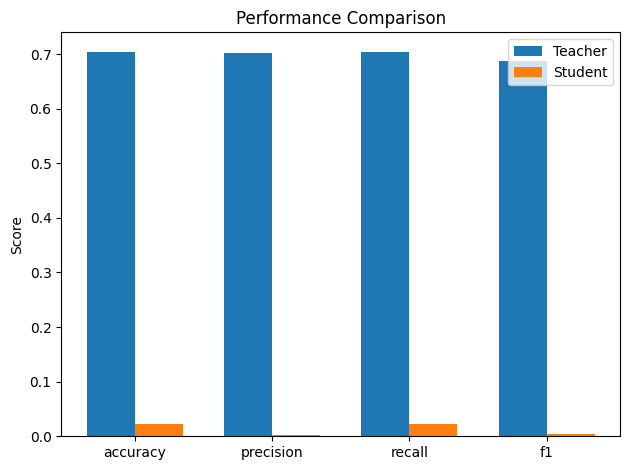

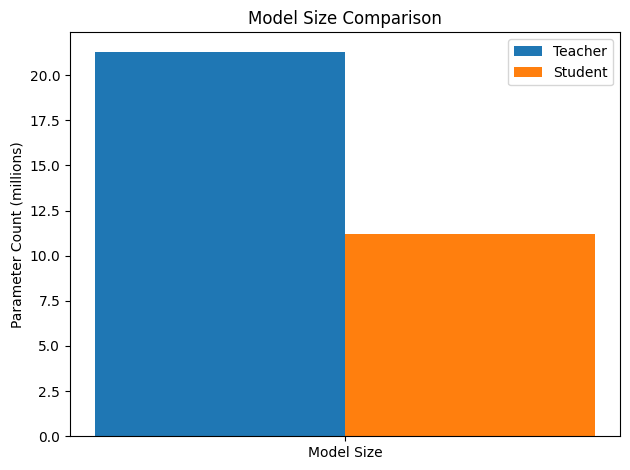

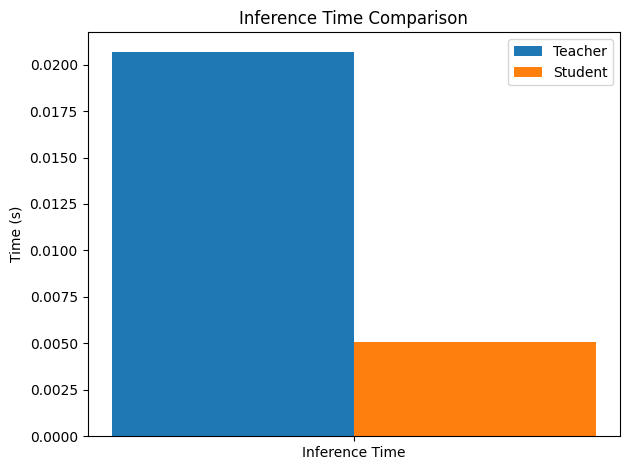

In [30]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics['metrics'][metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics['metrics'][metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [27]:
def calculate_recall(preds, targets, condition):
    """
    Calculate recall for a given condition in a multi-class setting.

    :param preds: Predicted classes.
    :param targets: True classes.
    :param condition: Boolean tensor indicating the condition (subset) for which to calculate recall.
    :return: Recall value.
    """
    if condition.sum() == 0:  # No samples meet the condition
        return 0.0

    filtered_preds = preds[condition]
    filtered_targets = targets[condition]

    true_positive = (filtered_preds == filtered_targets).sum().float()
    condition_positive = filtered_targets.size(0)

    recall = true_positive / condition_positive if condition_positive > 0 else 0.0
    return recall
    
def calculate_weighted_disparity(disparity_sums, counts):
    """
    Calculate weighted disparity for each class-attribute pair.
    """
    weighted_disparities = torch.zeros_like(disparity_sums)
    for class_idx in range(disparity_sums.size(0)):
        for attr_idx in range(disparity_sums.size(1)):
            if counts[class_idx][attr_idx] > 0:
                weighted_disparities[class_idx][attr_idx] = disparity_sums[class_idx][attr_idx] / counts[class_idx][attr_idx]
            else:
                weighted_disparities[class_idx][attr_idx] = 0.0
    return weighted_disparities

def evaluate_disparity(model, dataloader, num_classes, device):
    """
    Evaluate the disparity on the test data with weighted consideration.
    """
    model.eval()
    disparity_sums = None
    counts = None

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            targets = batch['label'].to(device)
            attributes = batch['target'].to(device)

            if disparity_sums is None:
                disparity_sums = torch.zeros(num_classes, attributes.size(1), device=device)
                counts = torch.zeros(num_classes, attributes.size(1), device=device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for class_idx in range(num_classes):
                for attr_idx in range(attributes.size(1)):
                    condition_present = (attributes[:, attr_idx] == 1) & (targets == class_idx)
                    condition_absent = (attributes[:, attr_idx] == 0) & (targets == class_idx)

                    if condition_present.sum() > 0 or condition_absent.sum() > 0:
                        recall_present = calculate_recall(preds, targets, condition_present)
                        recall_absent = calculate_recall(preds, targets, condition_absent)

                        disparity = abs(recall_present - recall_absent)
                        count = condition_present.sum() + condition_absent.sum()
                        disparity_sums[class_idx][attr_idx] += disparity * count
                        counts[class_idx][attr_idx] += count

    weighted_disparities = calculate_weighted_disparity(disparity_sums, counts)

    for class_idx in range(num_classes):
        for attr_idx in range(attributes.size(1)):
            print(f"Class: {class_idx}, Attr: {attr_idx}, Weighted Disparity: {weighted_disparities[class_idx][attr_idx]}")

    weighted_average = weighted_disparities.flatten()
    weighted_average = weighted_average.sum()/weighted_average.numel()
    return weighted_average

In [28]:
disparity = evaluate_disparity(student_model, testloader, num_classes=num_classes, device=device)
print(f'Average recall disparity across all attributes and classes: {disparity}')


Class: 0, Attr: 0, Weighted Disparity: 0.0
Class: 1, Attr: 0, Weighted Disparity: 0.0
Class: 2, Attr: 0, Weighted Disparity: 0.0
Class: 3, Attr: 0, Weighted Disparity: 0.0
Class: 4, Attr: 0, Weighted Disparity: 0.0
Class: 5, Attr: 0, Weighted Disparity: 0.0
Class: 6, Attr: 0, Weighted Disparity: 0.0
Class: 7, Attr: 0, Weighted Disparity: 0.0
Class: 8, Attr: 0, Weighted Disparity: 0.0
Class: 9, Attr: 0, Weighted Disparity: 0.044026415795087814
Class: 10, Attr: 0, Weighted Disparity: 0.0
Class: 11, Attr: 0, Weighted Disparity: 0.0
Class: 12, Attr: 0, Weighted Disparity: 0.0
Class: 13, Attr: 0, Weighted Disparity: 0.0
Class: 14, Attr: 0, Weighted Disparity: 0.0
Class: 15, Attr: 0, Weighted Disparity: 0.0
Class: 16, Attr: 0, Weighted Disparity: 0.0
Class: 17, Attr: 0, Weighted Disparity: 0.0
Class: 18, Attr: 0, Weighted Disparity: 0.0
Class: 19, Attr: 0, Weighted Disparity: 0.12697367370128632
Class: 20, Attr: 0, Weighted Disparity: 0.0
Class: 21, Attr: 0, Weighted Disparity: 0.0
Class: 22

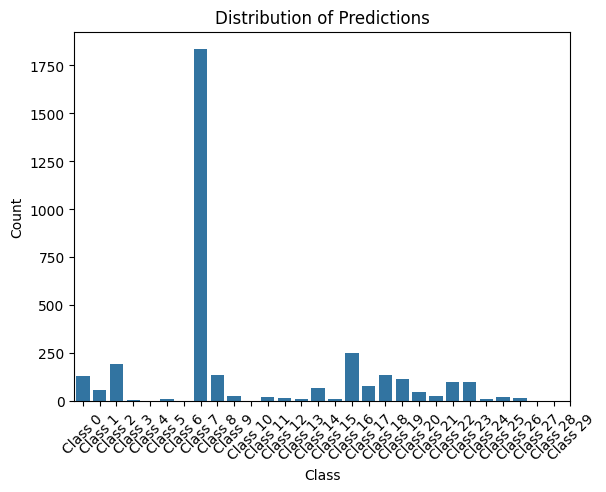

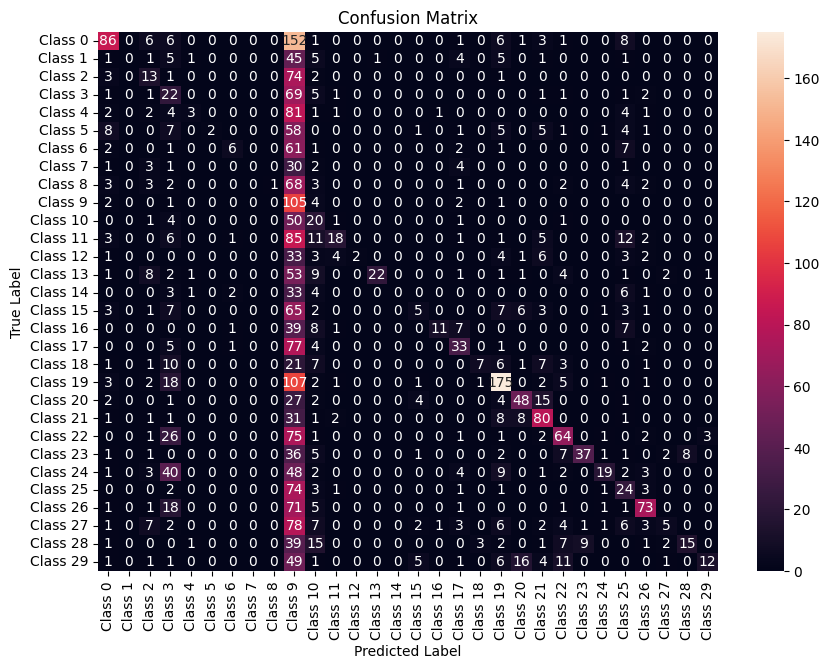

              precision    recall  f1-score   support

     Class 0       0.66      0.32      0.43       271
     Class 1       0.00      0.00      0.00        70
     Class 2       0.23      0.14      0.17        94
     Class 3       0.11      0.21      0.15       104
     Class 4       0.43      0.03      0.06       100
     Class 5       1.00      0.02      0.04        94
     Class 6       0.55      0.07      0.13        81
     Class 7       0.00      0.00      0.00        42
     Class 8       1.00      0.01      0.02        89
     Class 9       0.06      0.91      0.11       115
    Class 10       0.15      0.26      0.19        78
    Class 11       0.60      0.12      0.21       145
    Class 12       1.00      0.03      0.07        59
    Class 13       0.96      0.21      0.34       107
    Class 14       0.00      0.00      0.00        50
    Class 15       0.26      0.05      0.08       104
    Class 16       0.85      0.15      0.25        74
    Class 17       0.48    

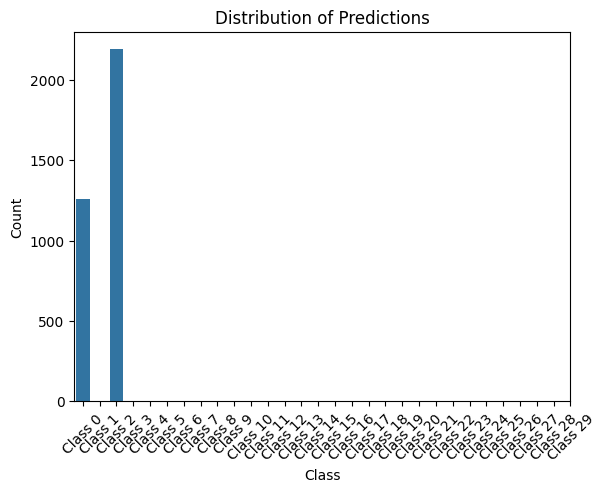

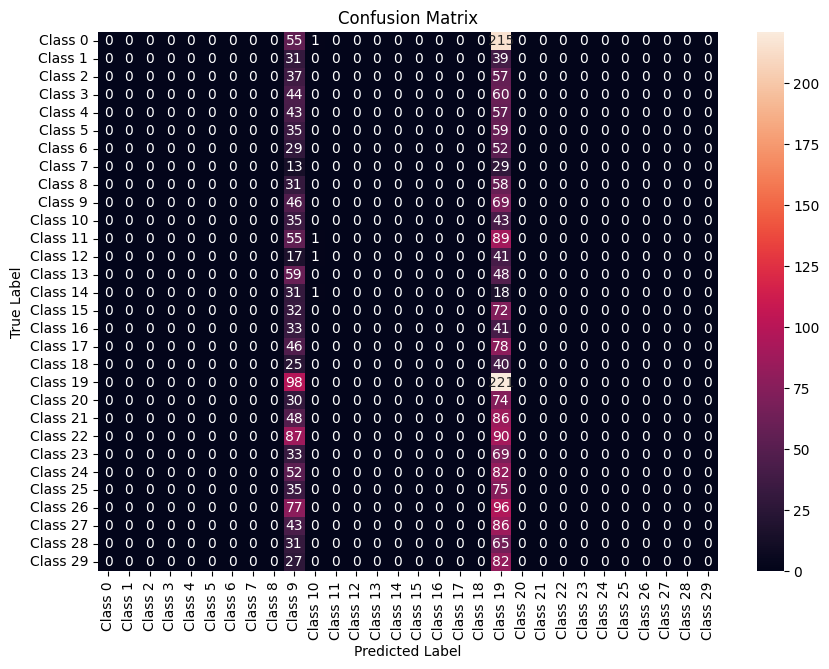

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       271
     Class 1       0.00      0.00      0.00        70
     Class 2       0.00      0.00      0.00        94
     Class 3       0.00      0.00      0.00       104
     Class 4       0.00      0.00      0.00       100
     Class 5       0.00      0.00      0.00        94
     Class 6       0.00      0.00      0.00        81
     Class 7       0.00      0.00      0.00        42
     Class 8       0.00      0.00      0.00        89
     Class 9       0.04      0.40      0.07       115
    Class 10       0.00      0.00      0.00        78
    Class 11       0.00      0.00      0.00       145
    Class 12       0.00      0.00      0.00        59
    Class 13       0.00      0.00      0.00       107
    Class 14       0.00      0.00      0.00        50
    Class 15       0.00      0.00      0.00       104
    Class 16       0.00      0.00      0.00        74
    Class 17       0.00    

In [29]:
class_names_new = [f"Class {label}" for label in range(30)]
def plot_prediction_distribution_and_confusion_matrix(labels, preds, class_names):
    # Plotting the distribution of predictions
    sns.countplot(x=preds)
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.show()

    # Computing the confusion matrix
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names_new, columns=class_names_new)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report for detailed metrics
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))

performance_metrics_teacher = compare_performance_metrics(teacher_model, student_model, testloader)
all_labels = performance_metrics_teacher['all_labels']
all_teacher_preds = performance_metrics_teacher['all_teacher_preds']
all_student_preds = performance_metrics_teacher['all_student_preds']

# For the Teacher Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_teacher_preds, class_names_new)

# For the Student Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_student_preds, class_names_new)

In [30]:
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
modules=list(student_model.children())[:-1]
student_features=nn.Sequential(*modules)

In [32]:
student_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [33]:
for name, param in student_model.named_parameters():
    if "weight" in name:  # assuming the last layer has a weight parameter
        last_layer_hidden_size = param.size(0)  # The first dimension is the hidden size
        break

In [34]:
last_layer_hidden_size

64

In [35]:
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  